### Import

In [10]:
import numpy as np
import pandas as pd
from urllib.request import urlopen
from bs4 import BeautifulSoup
import FinanceDataReader as fdr
from scipy.stats.mstats import gmean

import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ignore warnings
import warnings ; warnings.filterwarnings('ignore')

### Read Data

In [2]:
code_list = pd.read_csv('data/data_4908_20230912.csv', encoding='cp949')
code_list.shape

(2752, 12)

### Data Cleansing

$\bullet$ [W02_B_01] KRX에 등록된 회사명과 단축코드<br>
$~~$ http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020201

In [ ]:
code_list[['한글 종목명','단축코드']].to_csv('../ProcessedData/krx_code_list.csv', encoding='cp949')

$\bullet$ [W02_B_02 ~ W02_B_03] 금융위원회 종목<br>
$~~$ [마이페이지] -> [API신청] -> EndPoint 링크로 데이터를 불러온다.<br>
$~~$ https://www.data.go.kr/data/15094775/openapi.do

In [ ]:
key = "frp9m%2F2tsrmX8ySEWKRQPABZ0%2FhuA3tmcG53xJLo0n%2B3TgURv1aRXGOcqrxHdXW9SDc30IkK5hWiy6QcfpqIcg%3D%3D"
numOfRows = 3000
baseDate = 20230908

In [ ]:
# url = f"https://api.odcloud.kr/api/GetKrxListedInfoService/v1/getItemInfo?numOfRows={numOfRows}&basDt={baseDate}&serviceKey={key}"
url = f'https://apis.data.go.kr/1160100/service/GetKrxListedInfoService/getItemInfo?serviceKey={key}&basDt={baseDate}&numOfRows={numOfRows}'
result = urlopen(url) 
stock = BeautifulSoup(result, 'lxml-xml')

In [ ]:
stock = pd.DataFrame([i.text.split('\n')[1:-1] for i in stock.find_all("item")], 
                     columns= ["date", "market", "name", "fullName", "code", "fullCode", "bubinCode"])
stock['date'] = pd.to_datetime(stock['date'])
stock.set_index('date', inplace=True)
stock.head()

In [ ]:
# save data
stock.to_csv('../ProcessedData/listed_stock.csv')

$\bullet$ [W02_B_04] FinanceDataReader

In [3]:
# 예제로 samsung 주식을 불러온다.
samsung = fdr.DataReader('005930', '2020-01-01')
samsung.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921


In [4]:
# 전날 종가와 시가의 차이
samsung['GAP'] = samsung['Open'] - samsung['Close'].shift()

# 주가 단위를 만 원으로 설정
samsung = samsung / 10000

In [5]:
# index를 datetime64로 설정하면 resample method로 월별로 집계가 가능하다.
# samsung_monthly = samsung.resample('M').sum()
samsung_monthly = samsung.resample('M').last()

### 수익률
투자액 1원에 대해 어느 정도의 성과를 얻었는지를 나타내는 지표이다.
- 기대수익률:  투자 시 투자금 대비 얻고자 하는 수익 비율 
- 필수수익률(요구수익률): 위험이 같은 상품 중 최고수익률
- 기회비용: 투자자가 포기한 여러 대안 중 최고수익률
- 할인율

### 수익률 산출
- 수익률
  $$\large \text{수익률} = \frac{\text{총 수익} - \text{투자금액}}{\text{투자금액}} = \frac{P_1+D_1 - P_0}{P_0} = \frac{P_1 - P_0}{P_0} + \frac{D_1}{P_0} = \text{자본이득률} + \text{배당수익률}$$
$$(P_0 : \text{현재 주가}, P_1 : \text{투자시점 당시 주가}, D_1: \text{배당금})$$
  - $[-100\text{%}, \infty]$를 범위로 갖는다.
- 로그수익률(연속복리수익률): 이자를 n번 `균분지급`하는 상황의 수익률
  $$R_t = \frac{P_t+D_t - P_{t-1}}{P_{t-1}} = e^{r_t} - 1, ~R_t + 1 = (1 + \frac{r_t}{n})^n$$
  $$r_t = ln(P_t) - ln(P_{t-1})$$
  $$(R_t :\text{수익률},~ r_t: \text{로그수익률})$$
  - $[-\infty, \infty]$에서 0을 중심으로 좌우대칭된 분포로 통계분석에 유용하다.
  - 로그함수 성질에 따라 특정기간의 로그수익률을 각 시점의 수익률을 더하면 된다.
  

In [7]:
# (일반)수익률
samsung['Close'].pct_change().fillna(0)

Date
2020-01-02    0.000000
2020-01-03    0.005435
2020-01-06    0.000000
2020-01-07    0.005405
2020-01-08    0.017921
                ...   
2023-09-13    0.005674
2023-09-14    0.011283
2023-09-15    0.004184
2023-09-18   -0.025000
2023-09-19   -0.005698
Name: Close, Length: 921, dtype: float64

In [8]:
# 누적 (일반)수익률
(samsung['Close'].pct_change() + 1).cumprod() - 1

Date
2020-01-02         NaN
2020-01-03    0.005435
2020-01-06    0.005435
2020-01-07    0.010870
2020-01-08    0.028986
                ...   
2023-09-13    0.284420
2023-09-14    0.298913
2023-09-15    0.304348
2023-09-18    0.271739
2023-09-19    0.264493
Name: Close, Length: 921, dtype: float64

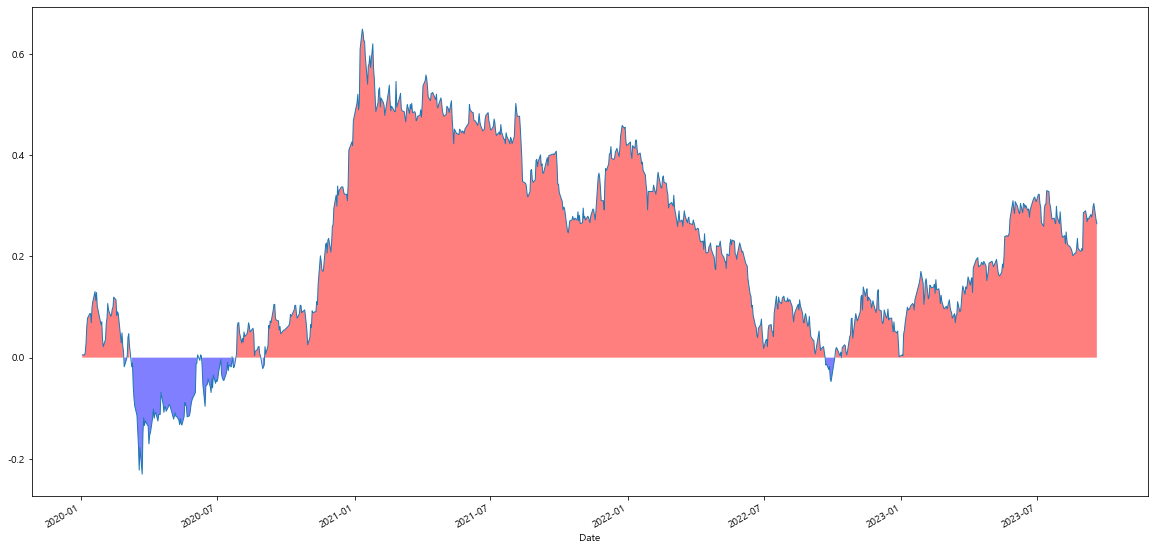

In [20]:
ease = (samsung['Close'].pct_change() + 1).cumprod() - 1
ease.plot(figsize=(20,10), linewidth=1)
plt.fill_between(ease.index, 0, ease, where=ease >= 0, facecolor='red', alpha=0.5)
plt.fill_between(ease.index, 0, ease, where=ease <= 0, facecolor='blue', alpha=0.5)

In [11]:
# 로그 수익률
np.log(samsung['Close'] / samsung['Close'].shift(1))

Date
2020-01-02         NaN
2020-01-03    0.005420
2020-01-06    0.000000
2020-01-07    0.005391
2020-01-08    0.017762
                ...   
2023-09-13    0.005658
2023-09-14    0.011220
2023-09-15    0.004175
2023-09-18   -0.025318
2023-09-19   -0.005714
Name: Close, Length: 921, dtype: float64

In [22]:
# 누적 로그수익률
np.log(samsung['Close'] / samsung['Close'].shift(1)).cumsum().fillna(0)

Date
2020-01-02    0.000000
2020-01-03    0.005420
2020-01-06    0.005420
2020-01-07    0.010811
2020-01-08    0.028573
                ...   
2023-09-13    0.250307
2023-09-14    0.261528
2023-09-15    0.265703
2023-09-18    0.240385
2023-09-19    0.234671
Name: Close, Length: 921, dtype: float64

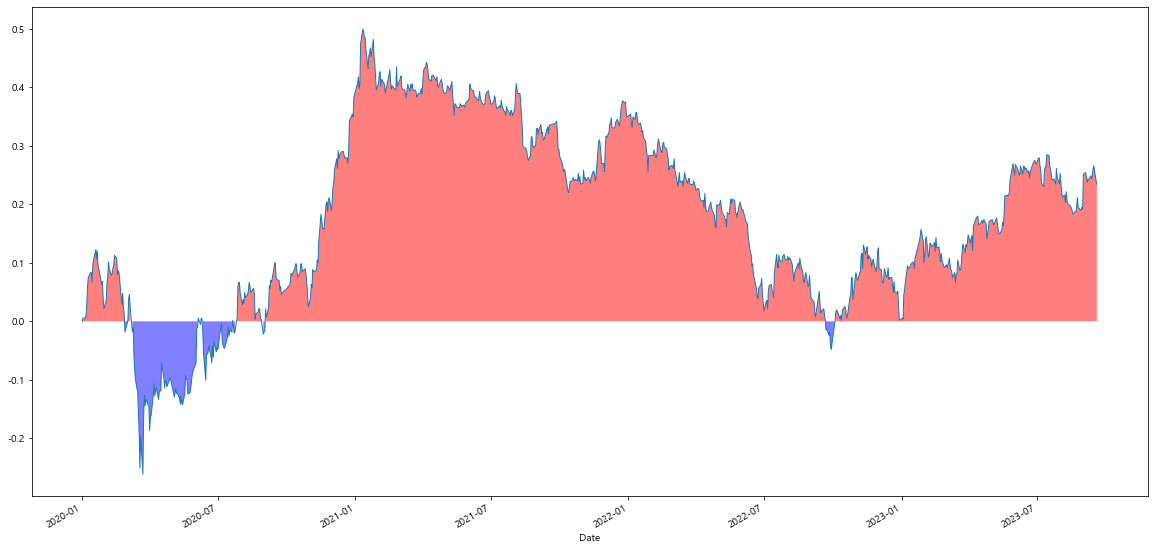

In [23]:
ease = np.log(samsung['Close'] / samsung['Close'].shift(1)).cumsum().fillna(0)
ease.plot(figsize=(20,10), linewidth=1)
plt.fill_between(ease.index, 0, ease, where=ease >= 0, facecolor='red', alpha=0.5)
plt.fill_between(ease.index, 0, ease, where=ease <= 0, facecolor='blue', alpha=0.5)

In [12]:
# 기간 로그수익률을 모두 더한 것으로 (최종가격 - 최초가격)/최초가격으로도 구할 수 있다.
# 일반적으로 기간 로그수익률이 기간 수익률보다 작다.
np.log(samsung['Close'] / samsung['Close'].shift(1)).sum()

0.23467105648527628

In [24]:
# 누적 로그 수익률로부터 지수변환으로 누적 수익률을 구할 수 있다.
ease.apply(np.exp) - 1

Date
2020-01-02    1.000000
2020-01-03    1.005435
2020-01-06    1.005435
2020-01-07    1.010870
2020-01-08    1.028986
                ...   
2023-09-13    1.284420
2023-09-14    1.298913
2023-09-15    1.304348
2023-09-18    1.271739
2023-09-19    1.264493
Name: Close, Length: 921, dtype: float64

### 기간수익률 산출
- 일반적으로 산술평균으로 구한다.
  $$ \frac{1}{n}\sum_{i=1}^n r_k$$
- `수익률의 변동성이 큰 것을 보수적으로 판단`하거나 복리 개념을 잘 반영하기 위해 기하평균을 사용하기도 한다.
 $$\sqrt[\large n\\\\]{\sum_{i=1}^n(1+r_k)} - 1$$

In [30]:
# 1000만원을 투자했으며 3년간 월 40% 수익, 30% 손실이 번갈아 이루어졌다.
returns = [0] + [0.4, -0.3] * 18

balances = [1000]
for r in returns[1:]:
    balances.append(balances[-1] * (1+r))
    
data = pd.DataFrame({'returns':returns, 'balances':balances})
data

,returns,balances
0,0.0,1000.000000
1,0.4,1400.000000
2,-0.3,980.000000
3,0.4,1372.000000
4,-0.3,960.400000
5,0.4,1344.560000
6,-0.3,941.192000
7,0.4,1317.668800
8,-0.3,922.368160
9,0.4,1291.315424


In [35]:
print(f"월수익률(산술): {data['returns'][1:].mean()}")
print(f"월수익률(기하): {gmean(data['returns'][1:]+1)-1}")

월수익률(산술): 0.05000000000000004
월수익률(기하): -0.010050506338833531


### 위험
기대수익률을 벌지 못하는 불확실성을 의미한다.<br>
- 위험이 큰 상품은 위험을 무릎쓰고 투자한 것에 대해 추가적인 보상, 위험프리미엄을 제공한다.
- 기대수익률과 다른 예상 외 수익률이 발생할 가능성이 높음을 의미하는 위험을 수익률의 표준편차로 정의한다.

In [39]:
# 투자금의 일부만 투자상태로 유지해 손실을 줄일 수 있다.
# 기간수익률 예제 상황에서 투자액의 40%만 유지한다.(분할투자)
# 16%(40%*0.4) 수익과 12%(30%*0.4) 손실이 번갈아 발생하는 꼴로 수익과 손실 사이 격차, 위험이 줄였다.
returns = [0] + list(map(lambda x: x*0.4, [0.4, -0.3])) * 18

balances = [1000]
for r in returns[1:]:
    balances.append(balances[-1] * (1+r))
    
data = pd.DataFrame({'returns':returns, 'balances':balances})
data

,returns,balances
0,0.00,1000.000000
1,0.16,1160.000000
2,-0.12,1020.800000
3,0.16,1184.128000
4,-0.12,1042.032640
5,0.16,1208.757862
6,-0.12,1063.706919
7,0.16,1233.900026
8,-0.12,1085.832023
9,0.16,1259.565146


In [8]:
gmeans = []
for p in np.linspace(0.0, 1.0, 100):
    returns = [0] + list(map(lambda x: x*p, [0.2,-0.3,0.4,-0.2]))
    gmeans.append(gmean(list(map(lambda x: x+1, returns))[1:])-1)

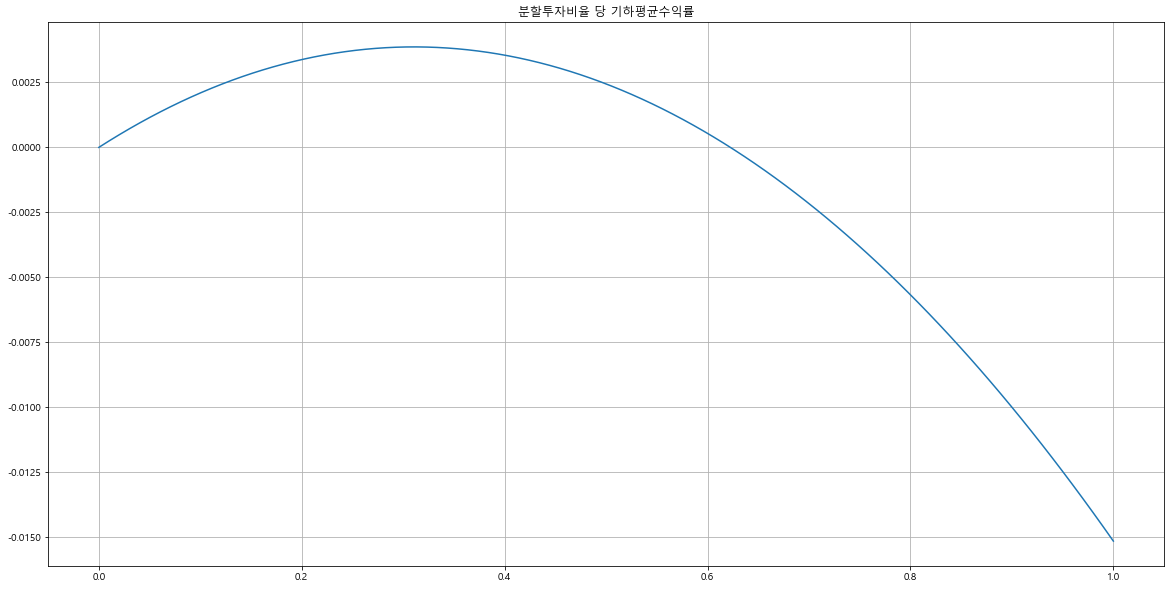

In [9]:
plt.figure(figsize=(20,10))
plt.plot(np.linspace(0.0, 1.0, 100), gmeans)
plt.title('분할투자비율 당 기하평균수익률')
plt.grid()
plt.show()

In [10]:
print(np.linspace(0.0, 1.01, 100)[np.array(gmeans).argmax()])

0.31626262626262625
